# Task: Predict the life_expectancy for 5 countries

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import os
%matplotlib inline
from sodapy import Socrata
import csv

## Checking & cleaning the dataset

In [151]:
dataset = pd.read_csv("Life_Expectancy_Data.csv")
# dataset_transpose = dataset.transpose()
print(dataset.shape)

(2938, 22)


In [152]:
dataset.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [153]:
# dataset.info()

In [154]:
#replacing all spaces with _ to be able to remove some coloms

orig_cols = list(dataset.columns)
new_cols = []
for col in orig_cols:
    new_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower())
dataset.columns = new_cols

In [155]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   hepatitis_b                      2385 non-null   float64
 9   measles                          2938 non-null   int64  
 10  bmi                              2904 non-null   float64
 11  under-five_deaths                2938 non-null   int64  
 12  polio               

In [156]:
dataset.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)

In [157]:
dataset.describe().iloc[:, 1:]


,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


### Things that may not make sense from above:
-Adult mortality of 1? This is likely an error in measuremet ,  May need to change to null if under a certain threshold.
-Infant deaths as low as 0 per 1000? That just isn't plausible - I think those values to actually be nulla and on the other end 1800 is likely an outlier, 
BMI of 1 and 87.3? A BMI of 15 or lower is seriously underweight and a BMI of 40 or higher is morbidly obese, therefore a large number of these measurements just seem unrealistic.
Under Five Deaths, similar to infant deaths just isn't likely (perhaps even impossible) to have values at zero.
GDP per capita min of 1.68 (USD) is doubtful for me- but perhaps values this low are outliers.


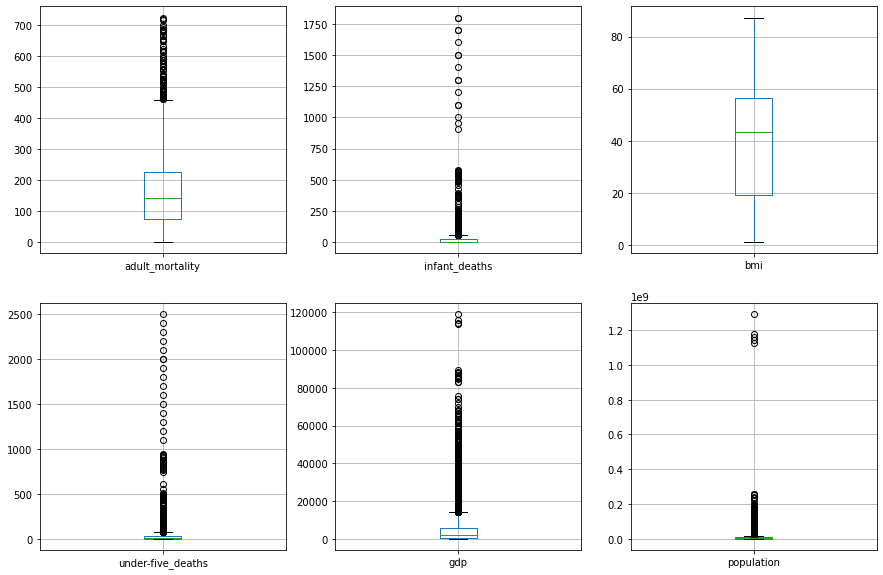

In [158]:
plt.figure(figsize=(15,10))
for i, col in enumerate(['adult_mortality', 'infant_deaths', 'bmi', 'under-five_deaths', 'gdp', 'population'], start=1):
    plt.subplot(2, 3, i)
    dataset.boxplot(col)

In [159]:
# There are a few of the above that could simply be outliers, but there are some that almost certainly have to be errors of some sort. 
# changes to null will be made for the following since these numbers don't make any sense


mort_5_percentile = np.percentile(dataset.adult_mortality.dropna(), 5)
dataset.adult_mortality = dataset.apply(lambda x: np.nan if x.adult_mortality < mort_5_percentile else x.adult_mortality, axis=1)
dataset.infant_deaths = dataset.infant_deaths.replace(0, np.nan)
dataset.bmi = dataset.apply(lambda x: np.nan if (x.bmi < 10 or x.bmi > 50) else x.bmi, axis=1)
dataset['under-five_deaths'] = dataset['under-five_deaths'].replace(0, np.nan)


In [160]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2783 non-null   float64
 5   infant_deaths                    2090 non-null   float64
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   hepatitis_b                      2385 non-null   float64
 9   measles                          2938 non-null   int64  
 10  bmi                              1482 non-null   float64
 11  under-five_deaths                2153 non-null   float64
 12  polio               

In [161]:
# breaking down the data into those that contain nulls in order to take a closer look. 

def nulls_breakdown(df=dataset):
    df_cols = list(dataset.columns)
    cols_total_count = len(list(df.columns))
    cols_count = 0
    for loc, col in enumerate(df_cols):
        null_count = df[col].isnull().sum()
        total_count = df[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('[iloc = {}] {} has {} null values: {}% null'.format(loc, col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(cols_total_count, cols_count, cols_percent_null))



In [162]:
nulls_breakdown()

[iloc = 3] life_expectancy has 10 null values: 0.34% null
[iloc = 4] adult_mortality has 155 null values: 5.28% null
[iloc = 5] infant_deaths has 848 null values: 28.86% null
[iloc = 6] alcohol has 194 null values: 6.6% null
[iloc = 8] hepatitis_b has 553 null values: 18.82% null
[iloc = 10] bmi has 1456 null values: 49.56% null
[iloc = 11] under-five_deaths has 785 null values: 26.72% null
[iloc = 12] polio has 19 null values: 0.65% null
[iloc = 13] total_expenditure has 226 null values: 7.69% null
[iloc = 14] diphtheria has 19 null values: 0.65% null
[iloc = 16] gdp has 448 null values: 15.25% null
[iloc = 17] population has 652 null values: 22.19% null
[iloc = 18] thinness_10-19_years has 34 null values: 1.16% null
[iloc = 19] thinness_5-9_years has 34 null values: 1.16% null
[iloc = 20] income_composition_of_resources has 167 null values: 5.68% null
[iloc = 21] schooling has 163 null values: 5.55% null
Out of 22 total columns, 16 contain null values; 72.73% columns contain null val

In [163]:
#Nearly half of the BMI variable's values are null, it is likely best to remove this variable altogether.
dataset.drop(columns='bmi', inplace=True)


In [164]:
dataset.describe().iloc[:, 1:]

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2928.000000,2783.000000,2090.000000,2744.000000,2938.000000,2385.000000,2938.000000,2153.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,69.224932,172.966942,42.599522,4.602861,738.251295,80.940461,2419.592240,57.362285,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,9.523867,122.083952,137.941420,4.052413,1987.914858,25.070016,11467.272489,185.077201,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,36.300000,13.000000,1.000000,0.010000,0.000000,1.000000,0.000000,1.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,63.100000,82.000000,2.000000,0.877500,4.685343,77.000000,0.000000,3.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,72.100000,148.000000,9.000000,3.755000,64.912906,92.000000,17.000000,11.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,75.700000,234.000000,33.000000,7.702500,441.534144,97.000000,360.250000,46.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


##  Outliers Detection

c:\users\maryame\miniconda3\envs\data-cleaning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\maryame\miniconda3\envs\data-cleaning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\maryame\miniconda3\envs\data-cleaning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

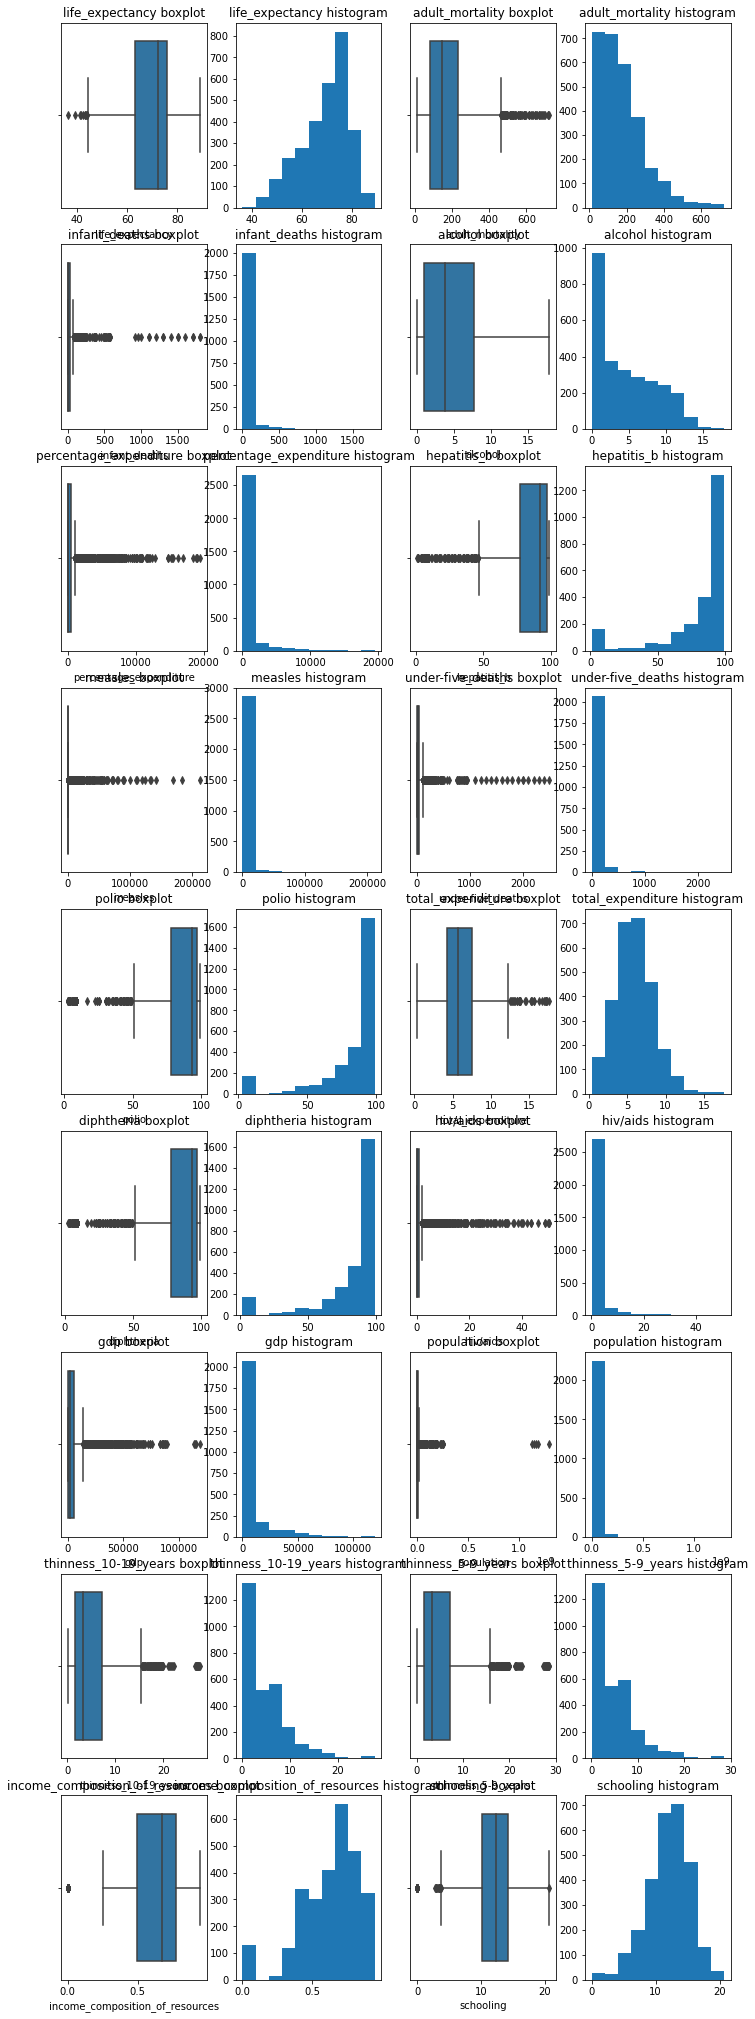

In [165]:
#boxplot and histogram will be created for each continuous variable in order to visually see if outliers exist

cont_vars = list(dataset.columns)[3:]
def outliers_visual(data):
    plt.figure(figsize=(12, 36))
    i = 0
    for col in cont_vars:
        i += 1
        plt.subplot(9, 4, i)
        sns.boxplot(data[col])
        plt.title('{} boxplot'.format(col))
        i += 1
        plt.subplot(9, 4, i)
        plt.hist(data[col])
        plt.title('{} histogram'.format(col))
    plt.show()
outliers_visual(dataset)


In [166]:
# Dealing with the Outliers and trying to drop them to keep much information as possible by winsorizing (limiting) the values for each variable on its own until no outliers remai
#  function below allows me to do exactly that by going variable by variable with the ability to use a lower limit and/or upper limit for winsorization. By default the function will show two boxplots side by side for the variable (one boxplot of the original data, and one with the winsorized change). Once a satisfactory limit is found (by visual analysis), the winsorized data will be saved in the wins_dict dictionary so the data can easily be accessed later.

def test_wins(col, lower_limit=0, upper_limit=0, show_plot=True):
    wins_data = winsorize(dataset[col], limits=(lower_limit, upper_limit))
    wins_dict[col] = wins_data
    if show_plot == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        sns.boxplot(dataset[col])
        plt.title('original {}'.format(col))
        plt.subplot(122)
        sns.boxplot(wins_data)
        plt.title('wins=({},{}) {}'.format(lower_limit, upper_limit, col))
        plt.show()
        
    

c:\users\maryame\miniconda3\envs\data-cleaning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\maryame\miniconda3\envs\data-cleaning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


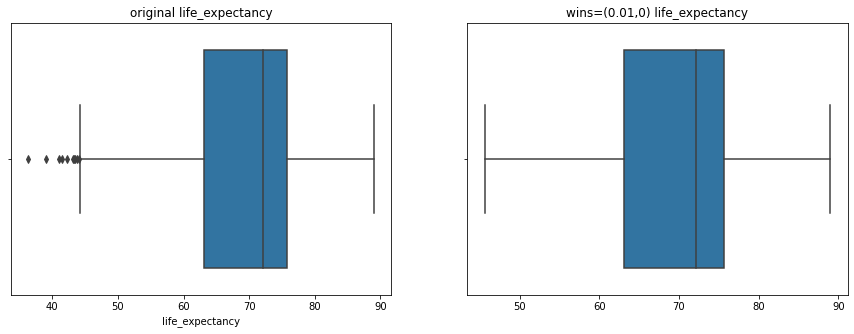

In [167]:
wins_dict = {}
test_wins(cont_vars[0], lower_limit=.01, show_plot=True)
test_wins(cont_vars[1], upper_limit=.04, show_plot=False)
test_wins(cont_vars[2], upper_limit=.05, show_plot=False)
test_wins(cont_vars[3], upper_limit=.0025, show_plot=False)
test_wins(cont_vars[4], upper_limit=.135, show_plot=False)
test_wins(cont_vars[5], lower_limit=.1, show_plot=False)
test_wins(cont_vars[6], upper_limit=.19, show_plot=False)
test_wins(cont_vars[7], upper_limit=.05, show_plot=False)
test_wins(cont_vars[8], lower_limit=.1, show_plot=False)
test_wins(cont_vars[9], upper_limit=.02, show_plot=False)
test_wins(cont_vars[10], lower_limit=.105, show_plot=False)
test_wins(cont_vars[11], upper_limit=.185, show_plot=False)
test_wins(cont_vars[12], upper_limit=.105, show_plot=False)
test_wins(cont_vars[13], upper_limit=.07, show_plot=False)
test_wins(cont_vars[14], upper_limit=.035, show_plot=False)
test_wins(cont_vars[15], upper_limit=.035, show_plot=False)
test_wins(cont_vars[16], lower_limit=.05, show_plot=False)
test_wins(cont_vars[17], lower_limit=.025, upper_limit=.005, show_plot=False)


In [168]:
# The plot above is an example of how the winsorization is visually inspected (the rest are not shown for brevity).

## Data exploration

In [169]:
#Before diving into exploration, a new dataframe with the winsorized data should be created.

wins_dataset = dataset.iloc[:, 0:3]
for col in cont_vars:
    wins_dataset[col] = wins_dict[col]

In [170]:
wins_dataset.describe()


,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2928.000000,2783.000000,2090.000000,2744.000000,2938.000000,2385.000000,2938.000000,2153.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2938.000000,2938.000000,2771.000000,2775.000000
mean,2007.518720,69.242008,172.966942,42.599522,4.602861,281.501093,85.065409,220.691287,57.362285,85.547448,5.93819,85.509078,0.526991,7483.158469,1.275338e+07,4.893975,4.927332,0.641306,12.056505
std,4.613841,9.477572,122.083952,137.941420,4.052413,384.161450,14.921632,329.192321,185.077201,15.313238,2.49832,15.256472,0.675962,14270.169342,6.101210e+07,4.273618,4.357365,0.176217,3.180035
min,2000.000000,45.600000,13.000000,1.000000,0.010000,0.000000,55.000000,0.000000,1.000000,52.000000,0.37000,52.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.291000,4.900000
25%,2004.000000,63.100000,82.000000,2.000000,0.877500,4.685343,77.000000,0.000000,3.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.600000,0.493000,10.100000
50%,2008.000000,72.100000,148.000000,9.000000,3.755000,64.912906,92.000000,17.000000,11.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.400000,3.400000,0.677000,12.300000
75%,2012.000000,75.700000,234.000000,33.000000,7.702500,441.534144,97.000000,360.250000,46.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.300000,7.300000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,1077.712092,99.000000,831.000000,2500.000000,99.000000,17.60000,99.000000,1.800000,119172.741800,1.293859e+09,17.100000,17.600000,0.948000,20.700000


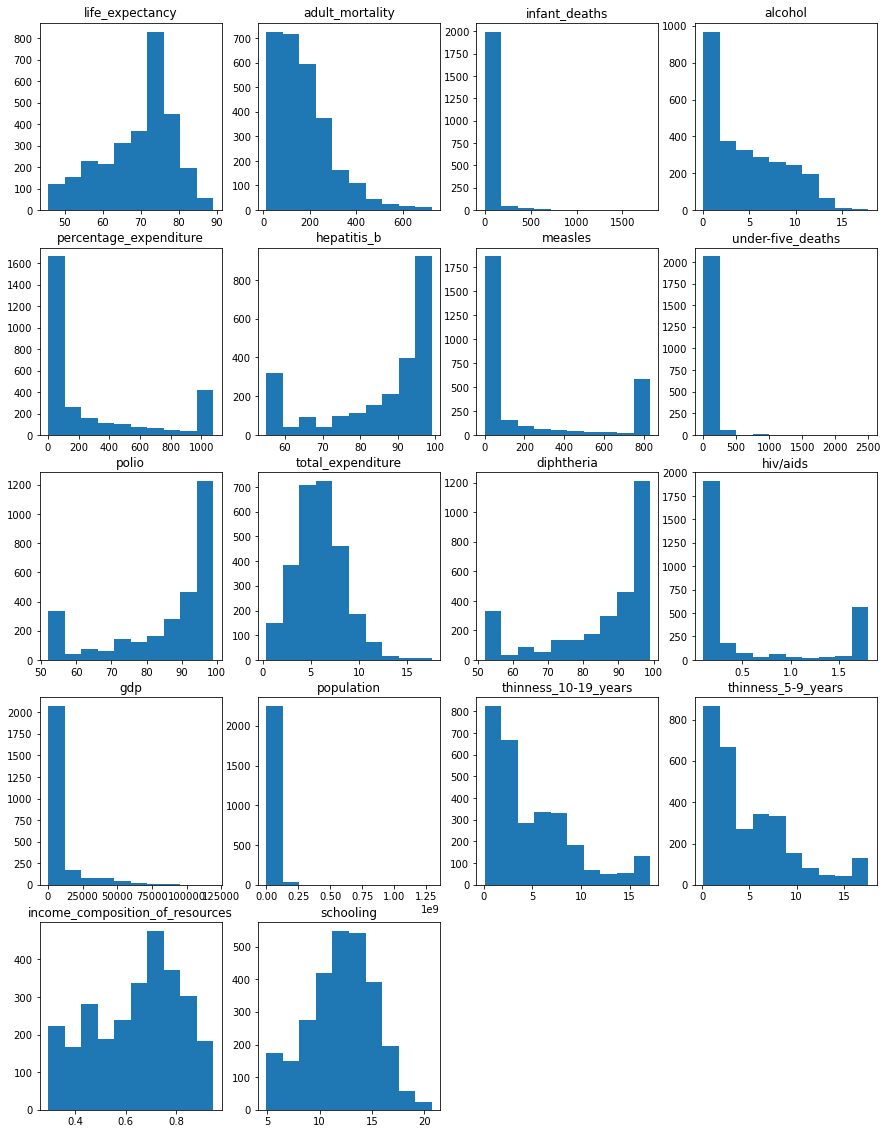

In [171]:
# Visual Distribution


plt.figure(figsize=(15, 20))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(5, 4, i)
    plt.hist(wins_dataset[col])
    plt.title(col)

##  Bivariate Analysis




### Continuous variables compared to the life expectancy (target variable) and to one another
### Categorical variables compared to the life expectancy (target variable)
### Comparison of Country Status and Year to Continuous variables (country has an extremely large number of values with small sample sizes, so country comparisons aren't especially helpful for this dataset)

In [172]:
#  Continuous to Continuous Analysis¶

wins_dataset[cont_vars].corr()



,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
life_expectancy,1.000000,-0.702286,-0.152651,0.406550,0.489283,0.340433,-0.337691,-0.186257,0.576466,0.221805,0.581845,-0.797089,0.463011,-0.021896,-0.517441,-0.512694,0.827898,0.776759
adult_mortality,-0.702286,1.000000,0.036705,-0.188158,-0.294402,-0.228830,0.207831,0.057214,-0.336149,-0.106537,-0.340364,0.608024,-0.289199,-0.018072,0.337739,0.342163,-0.531111,-0.457716
infant_deaths,-0.152651,0.036705,1.000000,-0.088300,-0.132562,-0.248481,0.314258,0.996539,-0.214137,-0.133187,-0.217945,0.047138,-0.104351,0.549962,0.317452,0.320363,-0.150144,-0.179521
alcohol,0.406550,-0.188158,-0.088300,1.000000,0.393345,0.131563,-0.201020,-0.088824,0.273331,0.296942,0.279530,-0.198786,0.354712,-0.035252,-0.447163,-0.436234,0.514871,0.563914
percentage_expenditure,0.489283,-0.294402,-0.132562,0.393345,1.000000,0.133129,-0.194687,-0.140824,0.267849,0.171070,0.267677,-0.295791,0.686245,-0.042911,-0.331475,-0.331954,0.563928,0.539029
hepatitis_b,0.340433,-0.228830,-0.248481,0.131563,0.133129,1.000000,-0.271256,-0.266578,0.685276,0.071775,0.740257,-0.281489,0.117284,-0.100578,-0.141983,-0.148906,0.321673,0.319036
measles,-0.337691,0.207831,0.314258,-0.201020,-0.194687,-0.271256,1.000000,0.324789,-0.322168,-0.160917,-0.317591,0.226305,-0.130453,0.187854,0.364480,0.368602,-0.282227,-0.339688
under-five_deaths,-0.186257,0.057214,0.996539,-0.088824,-0.140824,-0.266578,0.324789,1.000000,-0.241796,-0.132788,-0.246809,0.083004,-0.111260,0.538053,0.325283,0.326674,-0.178553,-0.202407
polio,0.576466,-0.336149,-0.214137,0.273331,0.267849,0.685276,-0.322168,-0.241796,1.000000,0.163164,0.855709,-0.478323,0.255906,-0.063413,-0.293851,-0.291875,0.535715,0.529150
total_expenditure,0.221805,-0.106537,-0.133187,0.296942,0.171070,0.071775,-0.160917,-0.132788,0.163164,1.000000,0.176930,-0.111482,0.138364,-0.079662,-0.282555,-0.289052,0.185090,0.261645


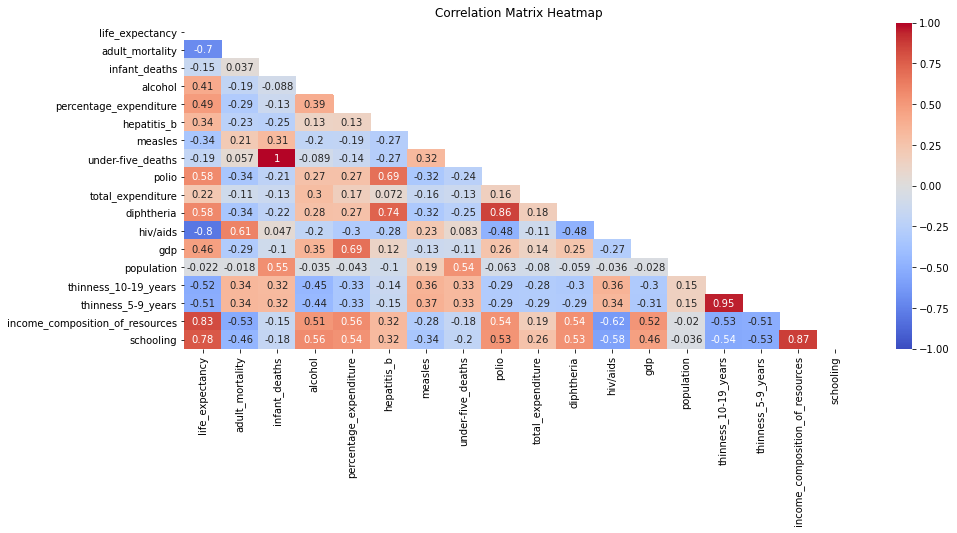

In [173]:
mask = np.triu(wins_dataset[cont_vars].corr())
plt.figure(figsize=(15,6))
sns.heatmap(wins_dataset[cont_vars].corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(18, 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

above heatmap is very useful! It very easily displays a number of important correlations between variables. Some general takeaways from the graphic above:

 - Life Expectancy (target variable) appears to be relatively highly correlated (negatively or positively) with:
 - Adult Mortality (negative)
 -HIV/AIDS (negative)
 -Income Composition of Resources (positive)
 -Schooling (positive)
 -Life expectancy (target variable) is extremely lowly correlated to population (nearly no correlation at all)
 -Infant deaths and Under Five deaths are extremely highly correlated
 -Percentage Expenditure and GDP are relatively highly correlated
 -Hepatitis B vaccine rate is relatively positively correlated with Polio and Diphtheria vaccine rates
 -Polio vaccine rate and Diphtheria vaccine rate are very positively correlated
 -HIV/AIDS is relatively negatively correlated with Income Composition of Resources
 -IThinness of 5-9 Year olds rate and Thinness of 10-15 Year olds rate is extremely highly correlated
 -Income Composition of Resources and Schooling are very highly correlated

In [177]:
# dropping the highly correlated ( corr >.7 or corr <.7)

dataset.drop(columns=['infant_deaths', 'percentage_expenditure','polio','thinness_10-19_years','schooling',', ], inplace=True)

c:\users\maryame\miniconda3\envs\data-cleaning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


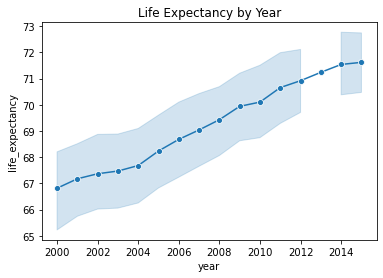

In [178]:
# looking at how life expectancy has changed over the years may be helpful

sns.lineplot('year', 'life_expectancy', data=wins_dataset, marker='o')
plt.title('Life Expectancy by Year')
plt.show()


In [179]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2783 non-null   float64
 5   alcohol                          2744 non-null   float64
 6   hepatitis_b                      2385 non-null   float64
 7   measles                          2938 non-null   int64  
 8   under-five_deaths                2153 non-null   float64
 9   total_expenditure                2712 non-null   float64
 10  diphtheria                       2919 non-null   float64
 11  hiv/aids                         2938 non-null   float64
 12  gdp                 

## Linear Regression 

In [194]:
# putting the target as last col 

cols = list(dataset.columns)
a, b = cols.index('income_composition_of_resources'), cols.index('life_expectancy')
cols[b], cols[a] = cols[a], cols[b]
new_dataset = dataset[cols]

In [195]:
new_dataset.head()

,country,year,status,income_composition_of_resources,adult_mortality,alcohol,hepatitis_b,measles,under-five_deaths,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_5-9_years,life_expectancy
0,Afghanistan,2015,Developing,0.479,263.0,0.01,65.0,1154,83.0,8.16,65.0,0.1,584.259210,33736494.0,17.3,65.0
1,Afghanistan,2014,Developing,0.476,271.0,0.01,62.0,492,86.0,8.18,62.0,0.1,612.696514,327582.0,17.5,59.9
2,Afghanistan,2013,Developing,0.470,268.0,0.01,64.0,430,89.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,59.9
3,Afghanistan,2012,Developing,0.463,272.0,0.01,67.0,2787,93.0,8.52,67.0,0.1,669.959000,3696958.0,18.0,59.5
4,Afghanistan,2011,Developing,0.454,275.0,0.01,68.0,3013,97.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,59.2


In [196]:
X = new_dataset.iloc[:, :-1].values
y = new_dataset.iloc[:, -1].values

In [198]:
print(X)

[['Afghanistan' 2015 'Developing' ... 584.2592099999999 33736494.0 17.3]
 ['Afghanistan' 2014 'Developing' ... 612.696514 327582.0 17.5]
 ['Afghanistan' 2013 'Developing' ... 631.744976 31731688.0 17.7]
 ...
 ['Zimbabwe' 2002 'Developing' ... 57.34834 125525.0 1.3]
 ['Zimbabwe' 2001 'Developing' ... 548.587312 12366165.0 1.7]
 ['Zimbabwe' 2000 'Developing' ... 547.3588785000001 12222251.0 11.2]]


In [202]:
print(y)

[65.  59.9 59.9 ... 44.8 45.3 46. ]


## Encoding categorical data

### Encoding the Independent Variable

In [203]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

### Encoding the Dependent Variable

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

## Splitting the dataset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [188]:
print(X_train)

[['South Africa' 2004 'Developing' ... 4863.51688 4717.99 15.0]
 ['Bulgaria' 2003 'Developed' ... 271.46824 7775327.0 2.4]
 ["Democratic People's Republic of Korea" 2007 'Developing' ... nan nan
  5.5]
 ...
 ['Guinea-Bissau' 2009 'Developing' ... 544.2227790000001 1517448.0 8.1]
 ['Belarus' 2004 'Developing' ... 2378.33927 973146.0 2.5]
 ['Guatemala' 2012 'Developing' ... 3299.65139 1527156.0 1.2]]


In [189]:
print(X_test)

[['Israel' 2013 'Developing' ... 36393.66932 8595.0 1.1]
 ['Uganda' 2010 'Developing' ... 594.9972557 33915133.0 6.0]
 ['Turkmenistan' 2002 'Developing' ... 967.917468 4612.0 3.5]
 ...
 ['Bhutan' 2011 'Developing' ... 2458.45976 7451.0 17.0]
 ['Argentina' 2014 'Developing' ... 12245.25645 42981515.0 0.9]
 ['Azerbaijan' 2008 'Developing' ... 5574.6382 87634.0 2.9]]


In [190]:
print(y_train)

[53.7 72.  68.5 ... 56.3 68.2 71.3]


In [191]:
print(y_test)

[82.1 58.4 63.3 67.9 47.8 89.  67.7 72.5 71.9 78.9 73.  83.  52.2 57.3
 72.3 59.2 75.3 72.5 61.9 53.2 72.2  nan 71.8 55.9 79.9 79.8 72.1 68.9
 68.8 51.1 69.3 54.9 73.6 73.4 78.9 76.1 67.8 81.1 74.4 72.1 75.2 80.
 71.6 59.4 68.4 72.9 62.5 67.8 73.6 50.  43.3 73.8 72.6 48.5 71.9 65.6
 65.9 73.1 61.8 67.5 51.4 47.1 59.2 66.6 77.3 74.  73.4 55.  81.  65.4
 79.5 81.  67.7 89.  71.  74.6 79.  74.8 76.2 82.9 67.7 72.8 69.  81.1
 62.  67.9 63.7 79.3 73.8 72.8 46.3 77.  62.3 81.1 77.  61.8 54.3 73.2
 66.7 71.5 66.3  nan 67.8 67.1 68.1 57.4 73.6 50.  57.  72.2 75.3 68.7
 74.2 81.9 57.9 59.8 72.2 68.4 77.6 76.  68.2 75.3 62.3 71.1 64.1 65.1
 75.8 74.7 69.9 65.1 87.  81.5 55.7 77.  73.  72.  65.7 77.6 52.8 62.1
 76.  62.5 56.  45.6 69.6 48.7 71.  67.  46.  73.  76.  79.2 76.4 63.5
 62.  74.2 69.4 74.7 62.9 80.  72.2 59.7 77.  56.7 49.6 76.2 74.7 55.
 65.9 68.8 75.  65.8 71.8 51.7 72.1 66.  74.8 81.  63.3 68.  82.7 72.7
 68.5 68.8 73.2 64.  73.4 65.  44.8 56.5 88.  79.9 68.8 46.  48.4 72.3
 54.7 72

## Feature scaling

In [206]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, 14:] = sc.fit_transform(X_train[:, 14:])
X_test[:, 14:] = sc.transform(X_test[:, 14:])

In [207]:
print(X_train)

[['South Africa' 2004 'Developing' ... -0.1833781631542145
  -0.20675242467085062 2.253039458322916]
 ['Bulgaria' 2003 'Developed' ... -0.5041539461912221
  -0.08530100914372872 -0.5496152137788345]
 ["Democratic People's Republic of Korea" 2007 'Developing' ... nan nan
  0.13992680872238977]
 ...
 ['Guinea-Bissau' 2009 'Developing' ... -0.48510078328208034
  -0.18310907821133585 0.718252375981481]
 ['Belarus' 2004 'Developing' ... -0.35697928464272494
  -0.1916162940922496 -0.527371922730408]
 ['Guatemala' 2012 'Developing' ... -0.2926213825638642
  -0.18295734617329093 -0.8165347063599535]]
